# Movie Studio Data Analysis — Data Understanding

This notebook covers the **Business Understanding** and **Data Understanding**
phases of the CRISP-DM framework.

The purpose of this notebook is to load, inspect, and prepare the datasets used
in the analysis, ensuring they are reliable and suitable for addressing the
business problem.

In [41]:
# Import pandas for working with tables (dataframes)
import pandas as pd

# Import sqlite3 to connect to the IMDb database
import sqlite3

# Import Path to safely work with file paths
from pathlib import Path

# Define where raw data is stored
RAW_DATA = Path("../data/raw")

# Define where processed (cleaned) data will be saved
PROCESSED_DATA = Path("../data/processed")

# Create the processed folder if it does not already exist
PROCESSED_DATA.mkdir(exist_ok=True)

## Business Context

The company plans to launch a new movie studio but lacks historical experience
in film production. To reduce financial risk, historical movie data is analyzed
to identify characteristics associated with box office success.

Understanding the structure, coverage, and limitations of the available data
is a necessary first step before performing deeper analysis and making
business recommendations.


## Data Sources

Multiple datasets from different sources are used in this project:

- **IMDb (SQLite database)**: Provides movie metadata and audience ratings.
  Data is accessed using SQL queries on the `im.db` file.
- **Box Office Mojo**: Contains domestic and international box office revenue.
- **The Numbers**: Provides production budget and revenue information.
- **TMDB**: Includes popularity metrics and additional movie metadata.
- **Supplementary datasets**: Movie information and review data.

Because these datasets were collected independently, inconsistencies and missing
values are expected.

## Accessing IMDb Data Using SQL

IMDb data is stored in a SQLite database (`im.db`). SQL queries are used to
extract only the tables and fields relevant to this analysis.

The primary tables queried are:
- `movie_basics`: movie titles, release years, runtimes, and genres
- `movie_ratings`: average audience ratings and vote counts

In [42]:
# Specify the path to the IMDb SQLite database file
imdb_db_path = RAW_DATA / "im.db"

# Create a connection to the SQLite database
conn = sqlite3.connect(imdb_db_path)

## Extracting Core IMDb Tables

The following SQL queries extract core movie metadata and audience ratings.
Movies without a release year are excluded to ensure that time-based analysis
can be performed in later stages.

In [43]:
# Use an SQL query to list all tables inside the IMDb database
pd.read_sql(
    """
SELECT name
FROM sqlite_master
WHERE type = 'table';
""",
    conn,
)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [44]:
# Use SQL to extract core movie information
# We only keep movies that have a release year
imdb_basics = pd.read_sql(
    """
SELECT
    movie_id,               -- unique movie ID
    primary_title,        -- movie title
    start_year,           -- year the movie was released
    runtime_minutes,      -- movie length
    genres                -- movie genres
FROM movie_basics
WHERE start_year IS NOT NULL;
""",
    conn,
)

In [45]:
# Use SQL to extract audience rating information
imdb_ratings = pd.read_sql(
    """
SELECT
    movie_id,               -- unique movie ID
    averagerating,       -- average IMDb rating
    numvotes             -- number of votes (popularity)
FROM movie_ratings;
""",
    conn,
)

# Close the database connection after extraction
conn.close()

## Initial Data Validation

After extracting the IMDb tables, basic validation is performed to confirm:

- The SQL queries executed successfully
- The number of records is reasonable
- Key variables such as release year and genre are present

This step helps identify potential data quality issues early in the workflow.

In [46]:
# Display the first few rows of each dataset
imdb_basics.head()
imdb_ratings.head()

# Check the number of rows and columns
imdb_basics.shape, imdb_ratings.shape

# Check how much data is missing in each column
imdb_basics.isna().mean()

movie_id           0.000000
primary_title      0.000000
start_year         0.000000
runtime_minutes    0.217176
genres             0.037005
dtype: float64

## Loading Additional Datasets

In addition to IMDb data, several datasets are provided as CSV files.
These datasets contain financial and supplementary movie information that
will be used in later stages of the analysis.

In [47]:
# Load Box Office Mojo data
bom = pd.read_csv(RAW_DATA / "bom.movie_gross.csv")

# Load The Numbers budget data
tn = pd.read_csv(RAW_DATA / "tn.movie_budgets.csv")

# Load TMDB movie data
tmdb = pd.read_csv(RAW_DATA / "tmdb.movies.csv")

# Load supplementary movie information
movie_info = pd.read_csv(RAW_DATA / "movie_info.csv")

# Load movie review data
movie_reviews = pd.read_csv(RAW_DATA / "movie_reviews.csv")

## Basic Data Standardization

To support future dataset integration, minimal standardization is applied:

- Movie titles are converted to lowercase and stripped of extra whitespace
- Year fields are converted to numeric values where applicable

At this stage, datasets are not merged. The objective is to prepare consistent
keys for downstream analysis.

In [48]:
# Define a helper function to clean movie titles
def clean_title(series):
    return (
        series.astype(str)  # ensure all values are strings
        .str.lower()  # convert to lowercase
        .str.strip()  # remove leading/trailing spaces
        .str.replace(r"\s+", " ", regex=True)  # remove extra spaces
    )


# Create cleaned title columns for future joining
imdb_basics["title_clean"] = clean_title(imdb_basics["primary_title"])
bom["title_clean"] = clean_title(bom["title"])
tn["title_clean"] = clean_title(tn["movie"])

# Convert year column to numeric format
bom["year"] = pd.to_numeric(bom["year"], errors="coerce")

## Saving Processed Datasets

Cleaned and standardized datasets are saved to the `data/processed` directory.
These processed files serve as inputs for subsequent analysis and visualization
steps.

In [49]:
# Save cleaned IMDb movie information
imdb_basics.to_csv(PROCESSED_DATA / "imdb_basics_clean.csv", index=False)

# Save cleaned IMDb ratings data
imdb_ratings.to_csv(PROCESSED_DATA / "imdb_ratings_clean.csv", index=False)

# Save cleaned Box Office Mojo data
bom.to_csv(PROCESSED_DATA / "bom_clean.csv", index=False)

# Save cleaned budget data
tn.to_csv(PROCESSED_DATA / "tn_budgets_clean.csv", index=False)

## High-Level Data Overview

A simple visualization is created to understand the distribution of movie
releases over time. This provides a general sense of dataset coverage without
drawing business conclusions.

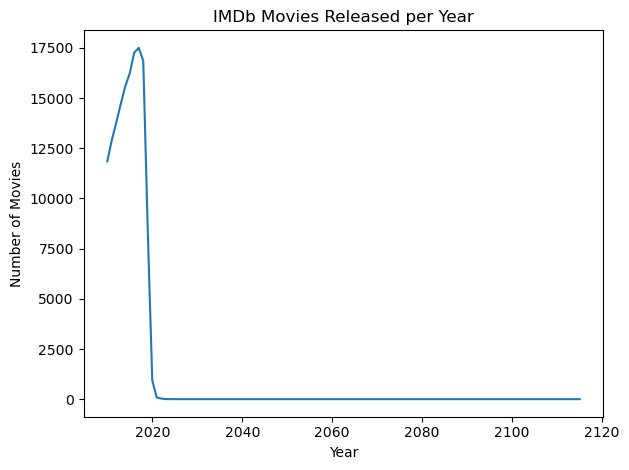

In [50]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Count how many movies were released each year
year_counts = imdb_basics["start_year"].value_counts().sort_index()

# Create a simple line chart
plt.figure()
year_counts.plot(kind="line")
plt.title("IMDb Movies Released per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

## Data Limitations and Assumptions

Several limitations should be considered when interpreting results from this data:

- Movie titles vary across datasets, making exact matching challenging
- IMDb genres are stored as multi-valued strings
- Revenue definitions differ across data sources
- Budget and foreign revenue data contain missing values
- Not all movies appear in every dataset

These limitations are documented to ensure transparency and responsible use
of the data in subsequent analysis stages.